### Stage I
#### Matrix Decomposition

In [5]:
# from mf.mf import godec
import numpy as np
import scipy.io as scio
import matplotlib.pyplot as plt
import copy
from sklearn.metrics import roc_curve, auc
import inspect
from alg_estimationC import est_c_LS
import seaborn as sns
from sklearn import metrics

casename = 'case39'
# plt.style.use('fivethirtyeight')
# Plot options
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['lines.markersize'] = 6
plt.rcParams['font.size'] = 16
plt.rcParams['font.weight'] = 'normal'
plt.rcParams["axes.labelweight"] = "normal"
plt.rcParams['figure.figsize'] = (5,4)
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['legend.loc'] = 'lower right'
plt.rcParams['legend.fontsize'] = 39
plt.rcParams['text.usetex'] = True#默认为false，此处设置为TRUE
plt.rcParams['font.family'] = 'Times New Roman'

In [6]:
def mean_absolute_error(new, true):
    mae_sum = []
    for i in range(new.shape[0]):
        e = new[i,:] - true[i,:]
        mae = np.linalg.norm(e, ord = 1)/new.shape[1]
        mae_sum.append(mae)
    return mae_sum

# def mean_error(new, true):
#     mae_sum = []
#     for i in range(new.shape[0]):
#         e = new[i,:] - true[i,:]
#         mae = np.sum(e)/new.shape[1]
#         mae_sum.append(mae)
#     return mae_sum

def absolute_error(new, true):
    aError = new - true
    # print(aError.shape)
    # Mean of 100 sets of data
    aError_mean = np.mean(aError,0)
    return aError_mean

def a_decect(a,times):
    no_mea = a.shape[1]
    a_true_sum = np.zeros((times,no_mea))
    for i in range(times):
        if i%2 == 0:
            a_true_sum[i, :] = a[i,:]
    return a_true_sum

def detection_label(H, a):
    Hmax = copy.deepcopy(H)
    Hmax = abs(Hmax)
    Hmax[Hmax == 0] = np.amax(Hmax) + 1
    ep = np.min(Hmax)
    y_pred = []
    for v in a:
        if np.max(abs(v))>ep:
            y_pred.append(1)
        else:
            y_pred.append(0)
    return y_pred

def retrieve_name(var):
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    return [var_name for var_name, var_val in callers_local_vars if var_val is var]

def get_iqr_data(datas):
    q1=np.quantile(datas,0.25)
    q2=np.median(datas)
    q3=np.quantile(datas,0.75)
    iqr=q3-q1
    up=q3+1.5*iqr
    return up

def c_bool(c):
    """
    The re-estimated injection phase angle c from decomposition：
    Convert the bus that are attacked to 1, the bus that are not attacked to 0
    """
    c_cvt = np.zeros((c.shape[0],c.shape[1]))

    for i in range(c.shape[0]):
        # c[i] = [abs(j) for j in c[i]]
        c_attacked = []
        c_abs = list(map(abs,c[i]))
        up = get_iqr_data(c_abs)
        for j in c_abs:
            if j > 0.1:
                c_attacked.append(1)
            else:
                c_attacked.append(0)
        c_cvt[i] = c_attacked
    return c_cvt

def bool_c(c_bool, c_new):
    c_cvt = c_bool*c_new
    return c_cvt

def a_bool(a):
    """
    The re-estimated injection phase angle a from decomposition：
    Convert the meters that are attacked to 1, the meters that are not attacked to 0
    """
    a_cvt = np.zeros((a.shape[0],a.shape[1]))

    for i in range(a.shape[0]):
        a_attacked = []
        a_abs = list(map(abs,a[i]))
        for j in a_abs:
            if j > 0.5:
                a_attacked.append(1)
            else:
                a_attacked.append(0)
        a_cvt[i] = a_attacked
    return a_cvt

def fpr_tpr(y_true, y_pred):
    [m,n] = y_true.shape
    y_true = y_true.reshape(m*n, 1)
    y_pred = y_pred.reshape(m*n, 1)

    tn, fp, fn, tp, = metrics.confusion_matrix(y_true, y_pred).ravel()

    fpr = fp / (fp + tn)
    tpr = tp / (tp + fn)

    return fpr,tpr

def est_a_LS(H, C_new, times):
    a_sure = []
    for i in range(times):
        a_est = H@C_new[i,:].T
        a_sure .append(a_est)
    a_sure  = np.array(a_sure )
    return a_sure

In [7]:
#load data 
path = f"XXX"
# z_sum0 = scio.loadmat(path+"\\z_0.mat")['z'][:,:,0]
z_sum5 = scio.loadmat(path+"/z_5.mat")['z'][:,:,0]
# z_sum10 = scio.loadmat(path+"\\z_10.mat")['z'][:,:,0]

# single-bus with 5% noise
za_sin5_sum = scio.loadmat(path+"/single/za_5.mat")['za'][:,:,0]
a_sin5_sum = scio.loadmat(path+"/single/a_5.mat")['a'][:,:,0]
c_sin5_true_sum = scio.loadmat(path+"/single/c_5.mat")['c'][:,:,0]

# uncoordinate multiple-bus with 5% noise
za_um5_sum = scio.loadmat(path+"/unmul/za_5.mat")['za'][:,:,0]
a_um5_sum = scio.loadmat(path+"/unmul/a_5.mat")['a'][:,:,0]
c_um5_true_sum = scio.loadmat(path+"/unmul/c_5.mat")['c'][:,:,0]

# coordinate multiple-bus with 5% noise
za_co5_sum = scio.loadmat(path+"/comul/za_5.mat")['za'][:,:,0]
a_co5_sum = scio.loadmat(path+"/comul/a_5.mat")['a'][:,:,0]
c_co5_true_sum = scio.loadmat(path+"/comul/c_5.mat")['c'][:,:,0]


H = scio.loadmat(path+"/H.mat")['h']
Wr_5 = scio.loadmat(path+"/W-5.mat")['w']
# Wr_10 = scio.loadmat(path+"\\W-10.mat")['w']
P_inv = np.linalg.inv(H.T@H)
# P_noise_inv_5 = np.linalg.inv(H.T@Wr_5@H)
# P_noise_inv_10 = np.linalg.inv(H.T@Wr_10@H)

# config
att_times = 100


# LRMF
a_new_sin5_sum = scio.loadmat(path+"/LRMF/a_new/a_new_single5.mat")['A']
a_new_um5_sum = scio.loadmat(path+"/LRMF/a_new/a_new_unmul5.mat")['A']
a_new_co5_sum = scio.loadmat(path+"/LRMF/a_new/a_new_comul5.mat")['A']

# ADMM
aa_new_sin5_sum = scio.loadmat(path+"/ADMM/a_new/a_new_single5.mat")['A']
aa_new_um5_sum = scio.loadmat(path+"/ADMM/a_new/a_new_unmul5.mat")['A']
aa_new_co5_sum = scio.loadmat(path+"/ADMM/a_new/a_new_comul5.mat")['A']

# GoDEC
ag_new_sin5_sum = scio.loadmat(path+"/GoDEC/a_new/a_new_single5.mat")['A']
ag_new_um5_sum = scio.loadmat(path+"/GoDEC/a_new/a_new_unmul5.mat")['A']
ag_new_co5_sum = scio.loadmat(path+"/GoDEC/a_new/a_new_comul5.mat")['A']

- Estimate injected error vector

In [8]:
# LRMF
c_new_single5_sum = est_c_LS(H, P_inv, a_new_sin5_sum, att_times)
c_new_unmul5_sum = est_c_LS(H, P_inv, a_new_um5_sum, att_times)
c_new_comul5_sum = est_c_LS(H, P_inv, a_new_co5_sum, att_times)


# godec
cg_new_single5_sum = est_c_LS(H, P_inv, ag_new_sin5_sum, att_times)
cg_mae_sin5 = mean_absolute_error(cg_new_single5_sum, c_sin5_true_sum)

cg_new_unmul5_sum = est_c_LS(H, P_inv, ag_new_um5_sum, att_times)
cg_mae_um5 = mean_absolute_error(cg_new_unmul5_sum, c_um5_true_sum)

cg_new_comul5_sum = est_c_LS(H, P_inv, ag_new_co5_sum, att_times)
cg_mae_co5 = mean_absolute_error(cg_new_comul5_sum, c_co5_true_sum)

# admm
ca_new_single5_sum = est_c_LS(H, P_inv, aa_new_sin5_sum, att_times)
ca_mae_sin5 = mean_absolute_error(ca_new_single5_sum, c_sin5_true_sum)

ca_new_unmul5_sum = est_c_LS(H, P_inv, aa_new_um5_sum, att_times)
ca_mae_um5 = mean_absolute_error(ca_new_unmul5_sum, c_um5_true_sum)

ca_new_comul5_sum = est_c_LS(H, P_inv, aa_new_co5_sum, att_times)
ca_mae_co5 = mean_absolute_error(ca_new_comul5_sum, c_co5_true_sum)

# attack_type_list = [c_new_single5_sum,c_new_unmul5_sum,c_new_comul5_sum]

# for i in attack_type_list:
#     # print(retrieve_name(i))
#     name = retrieve_name(i)[0]
#     # print(name)
#     dir = f"{path}\c_new\{name}.mat"
#     scio.savemat(dir, {'cnew': i})

- Convert to bool

In [9]:
c_new_single5_bool = c_bool(c_new_single5_sum)
c_new_unmul5_bool = c_bool(c_new_unmul5_sum)
c_new_comul5_bool = c_bool(c_new_comul5_sum)

ca_new_single5_bool = c_bool(ca_new_single5_sum)
ca_new_unmul5_bool = c_bool(ca_new_unmul5_sum)
ca_new_comul5_bool = c_bool(ca_new_comul5_sum)

cg_new_single5_bool = c_bool(cg_new_single5_sum)
cg_new_unmul5_bool = c_bool(cg_new_unmul5_sum)
cg_new_comul5_bool = c_bool(cg_new_comul5_sum)

c_sin5_true_bool = c_bool(c_sin5_true_sum)
c_um5_true_bool = c_bool(c_um5_true_sum)
c_co5_true_bool = c_bool(c_co5_true_sum)

a_new_single5_bool = a_bool(a_new_sin5_sum)
a_new_unmul5_bool = a_bool(a_new_um5_sum)
a_new_comul5_bool = a_bool(a_new_co5_sum)

aa_new_single5_bool = a_bool(aa_new_sin5_sum)
aa_new_unmul5_bool = a_bool(aa_new_um5_sum)
aa_new_comul5_bool = a_bool(aa_new_co5_sum)

ag_new_single5_bool = a_bool(ag_new_sin5_sum)
ag_new_unmul5_bool = a_bool(ag_new_um5_sum)
ag_new_comul5_bool = a_bool(ag_new_co5_sum)

a_sin5_true_bool = a_bool(a_sin5_sum)
a_um5_true_bool = a_bool(a_um5_sum)
a_co5_true_bool = a_bool(a_co5_sum)

- Verification by D-FACTS

In [10]:
from HDS.DCSE.pgse_env import pgse_env
from HDS.DCSE.config.config_mea_idx import define_mea_idx_noise
from HDS.DCSE.gendata.gen_load import gen_case, gen_load_data
from HDS.DCSE.MTD import mtd

from pypower.api import *
from pypower.idx_bus import *
from pypower.idx_brch import *
from pypower.idx_gen import *


In [11]:
    case_name = 'case39'
    case = case39()
    case = gen_case(case, case_name) 
    mea_idx, no_mea, noise_sigma = define_mea_idx_noise(case, 'FULL')
    case_env = pgse_env(case = case, case_name = case_name, noise_sigma = noise_sigma, idx = mea_idx, fpr = 0.05)

    src_dir = "XXX"
    _, _ = gen_load_data(case, case_name, src_dir)


Run on the default load condition.
Initial OPF tests ok.
************************************************************
Load file found, loading the data...


In [12]:
pb = mtd(case_env=case_env)

#LRMF
c_sure_sin5_bool = pb.att_verify_loop(c_sin5_true_sum,c_new_single5_sum,att_times)
c_sure_um5_bool = pb.att_verify_loop(c_um5_true_sum,c_new_unmul5_sum,att_times)
c_sure_co5_bool = pb.att_verify_loop(c_co5_true_sum,c_new_comul5_sum,att_times)


In [13]:
c_sure_sin5_sum = bool_c(c_sure_sin5_bool, c_new_single5_sum)
c_sure_um5_sum = bool_c(c_sure_um5_bool, c_new_unmul5_sum)
c_sure_co5_sum = bool_c(c_sure_co5_bool, c_new_comul5_sum)

a_sure_sin5_sum = est_a_LS(H, c_sure_sin5_sum, att_times)
a_sure_um5_sum = est_a_LS(H, c_sure_um5_sum, att_times)
a_sure_co5_sum = est_a_LS(H, c_sure_co5_sum, att_times)

In [14]:
c_sure_sin5_bool = c_bool(c_sure_sin5_sum)
c_sure_um5_bool = c_bool(c_sure_um5_sum)
c_sure_co5_bool = c_bool(c_sure_co5_sum)

a_sure_sin5_bool = a_bool(a_sure_sin5_sum)
a_sure_um5_bool = a_bool(a_sure_um5_sum)
a_sure_co5_bool = a_bool(a_sure_co5_sum)

# scio.savemat(path+"/LRMF/sure/a_sure_sin5.mat", {'asure': a_sure_sin5_sum})
# scio.savemat(path+"/LRMF/sure/c_sure_sin5.mat", {'csure': c_sure_sin5_sum})

- FPR and TPR

In [15]:
# a
fp_lrmf_sin5, tp_lrmf_sin5 = fpr_tpr(a_sin5_true_bool, a_new_single5_bool )
fp_lrmf_um5, tp_lrmf_um5 = fpr_tpr(a_um5_true_bool, a_new_unmul5_bool)
fp_lrmf_co5, tp_lrmf_co5 = fpr_tpr(a_co5_true_bool, a_new_comul5_bool)

fp_admm_sin5, tp_admm_sin5 = fpr_tpr(a_sin5_true_bool, aa_new_single5_bool)
fp_admm_um5, tp_admm_um5 = fpr_tpr(a_um5_true_bool, aa_new_unmul5_bool)
fp_admm_co5, tp_admm_co5 = fpr_tpr(a_co5_true_bool, aa_new_comul5_bool)

fp_godec_sin5, tp_godec_sin5 = fpr_tpr(a_sin5_true_bool, ag_new_single5_bool)
fp_godec_um5, tp_godec_um5 = fpr_tpr(a_um5_true_bool, ag_new_unmul5_bool)
fp_godec_co5, tp_godec_co5 = fpr_tpr(a_co5_true_bool, ag_new_comul5_bool)

fp_dems_sin5, tp_dems_sin5 = fpr_tpr(a_sin5_true_bool, a_sure_sin5_bool)
fp_dems_um5, tp_dems_um5 = fpr_tpr(a_um5_true_bool, a_sure_um5_bool)
fp_dems_co5, tp_dems_co5 = fpr_tpr(a_co5_true_bool, a_sure_co5_bool)


In [17]:
# c
fp_lrmf_single5, tp_lrmf_single5 = fpr_tpr(c_sin5_true_bool,c_new_single5_bool )
fp_lrmf_unmul5, tp_lrmf_unmul5 = fpr_tpr(c_um5_true_bool, c_new_unmul5_bool)
fp_lrmf_comul5, tp_lrmf_comul5 = fpr_tpr(c_co5_true_bool, c_new_comul5_bool)

fp_admm_single5, tp_admm_single5 = fpr_tpr(c_sin5_true_bool, c_new_single5_bool)
fp_admm_unmul5, tp_admm_unmul5 = fpr_tpr(c_um5_true_bool, ca_new_unmul5_bool)
fp_admm_comul5, tp_admm_comul5 = fpr_tpr(c_co5_true_bool, ca_new_comul5_bool)

fp_godec_single5, tp_godec_single5 = fpr_tpr(c_sin5_true_bool, cg_new_single5_bool)
fp_godec_unmul5, tp_godec_unmul5 = fpr_tpr(c_um5_true_bool, cg_new_unmul5_bool)
fp_godec_comul5, tp_godec_comul5 = fpr_tpr(c_co5_true_bool, cg_new_comul5_bool)

fp_dems_single5, tp_dems_single5 = fpr_tpr(c_sin5_true_bool, c_sure_sin5_bool)
fp_dems_unmul5, tp_dems_unmul5 = fpr_tpr(c_um5_true_bool, c_sure_um5_bool)
fp_dems_comul5, tp_dems_comul5 = fpr_tpr(c_co5_true_bool, c_sure_co5_bool)


- CDF before and after D-FACTS

In [19]:
a_mae_sin5 = mean_absolute_error(a_new_sin5_sum, a_sin5_sum)
a_mae_um5 = mean_absolute_error(a_new_um5_sum, a_um5_sum)
a_mae_co5 = mean_absolute_error(a_new_co5_sum, a_co5_sum)

c_mae_sin5 = mean_absolute_error(c_new_single5_sum, c_sin5_true_sum)
c_mae_um5 = mean_absolute_error(c_new_unmul5_sum, c_um5_true_sum)
c_mae_co5 = mean_absolute_error(c_new_comul5_sum, c_co5_true_sum)

as_mae_sin5 = mean_absolute_error(a_sure_sin5_sum, a_sin5_sum)
as_mae_um5 = mean_absolute_error(a_sure_um5_sum, a_um5_sum)
as_mae_co5 = mean_absolute_error(a_sure_co5_sum, a_co5_sum)

cs_mae_sin5 = mean_absolute_error(c_sure_sin5_sum, c_sin5_true_sum)
cs_mae_um5 = mean_absolute_error(c_sure_um5_sum, c_um5_true_sum)
cs_mae_co5 = mean_absolute_error(c_sure_co5_sum, c_co5_true_sum)

In [53]:
import pandas as pd
colname = ['Sg.','UnM.\n$\mathbf{\mathit{\hat{c}}}$','CoM.','Sg.','UnM.\n$\mathbf{\mathit{\hat{c}_{acc}}}$','CoM.']
data_row = np.array([c_mae_sin5, c_mae_um5, c_mae_co5, cs_mae_sin5, cs_mae_sin5, cs_mae_sin5]).T

colname_a = ['Sg.','UnM.\n$\mathbf{\mathit{\hat{a}}}$','CoM.','Sg.','UnM.\n$\mathbf{\mathit{\hat{a}_{acc}}}$','CoM.']
data_row_a = np.array([a_mae_sin5, a_mae_um5, a_mae_co5, as_mae_sin5, as_mae_um5, as_mae_co5]).T

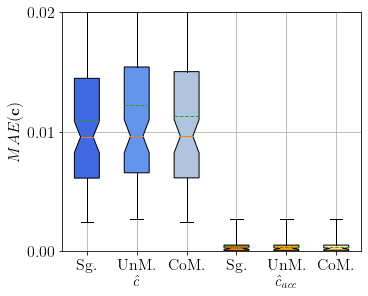

In [56]:
bplot = plt.boxplot(data_row,meanline=True,showmeans=True,labels=colname,notch=True,patch_artist=True, whis=5)
plt.grid()
ylabel = np.linspace(0, 0.02, 3)
plt.yticks(ylabel)
plt.ylim(0,0.02)
plt.ylabel(r'$MAE(\mathbf{c})$')

colors = ['royalblue', 'CornflowerBlue', 'LightSteelBlue', 'Chocolate','Orange','Moccasin']
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)


plt.savefig("/Users/dqy/Desktop/code0312/HDS/pic/case39/c39-mae-box.eps", dpi=600)


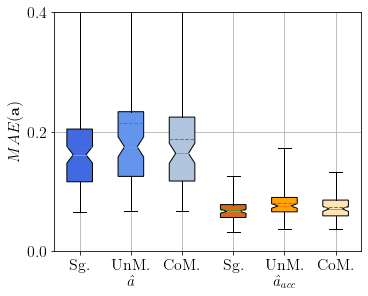

In [59]:
bplot = plt.boxplot(data_row_a,meanline=True,showmeans=True,labels=colname_a,notch=True,patch_artist=True, whis=10)
plt.grid()
ylabel = np.linspace(0, 0.4, 3)
plt.yticks(ylabel)
plt.ylim(0,0.4)
plt.ylabel(r'$MAE(\mathbf{a})$')

colors = ['royalblue', 'CornflowerBlue', 'LightSteelBlue', 'Chocolate','Orange','Moccasin']
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

plt.savefig("/Users/dqy/Desktop/code0312/HDS/pic/case39/a39-mae-box.eps", dpi=600)